In [1]:
import os
import numpy as np
import pandas as pd
import re
import seaborn as sns
from matplotlib import pyplot as plt

    
import statsmodels.api as sm
from scipy.stats import pearsonr
from sklearn import preprocessing

import file_structure
(origdir,basedir,imagedir,normdir,splitdir,out_dir,model_dir) = file_structure.file_dirs('texture')

In [2]:

import load_data
(all_samples, all_pca , all_1p19q, all_age,
 all_KPS, all_gender, all_id, all_feat_names)= load_data.load_data('all',0,'cmb')
all_idstr = np.expand_dims(np.load(os.path.join(splitdir,'label_idstr.npy'),allow_pickle=True),1)
# print(all_idstr)

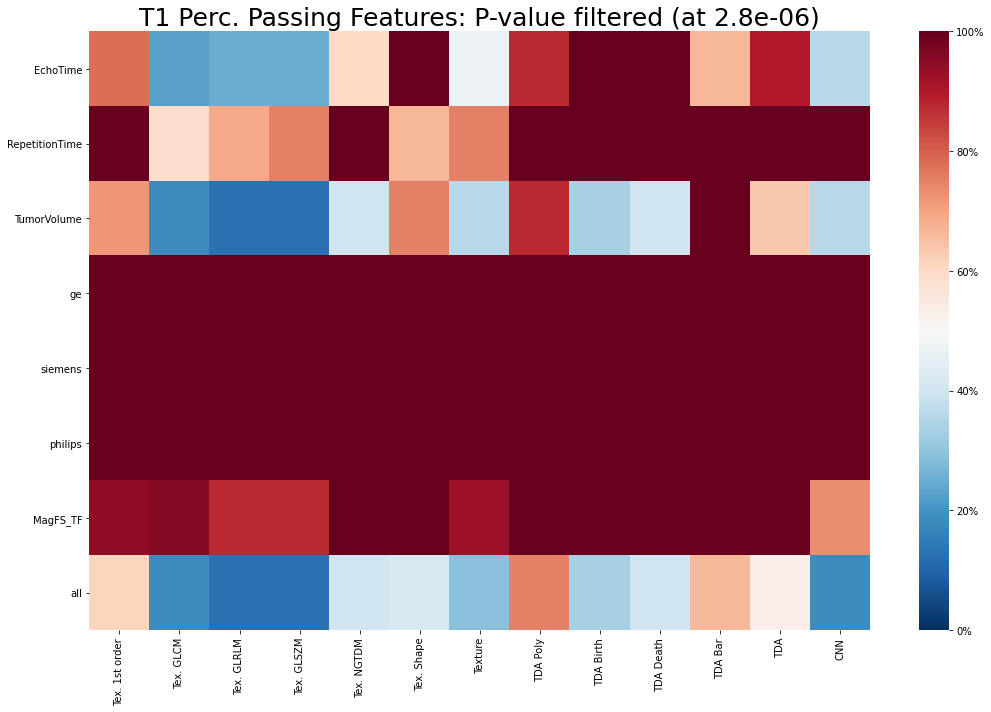

T1                 Tex. 1st order  Tex. GLCM  Tex. GLRLM  Tex. GLSZM  Tex. NGTDM  \
EchoTime                    14          5           4           4           3   
RepetitionTime              18         13          11          12           5   
TumorVolume                 13          4           2           2           2   
ge                          18         22          16          16           5   
siemens                     18         22          16          16           5   
philips                     18         22          16          16           5   
MagFS_TF                    17         21          14          14           5   
all                         11          4           2           2           2   

                Tex. Shape  Texture  TDA Poly  TDA Birth  TDA Death  TDA Bar  \
EchoTime                12       42         7          6         10        4   
RepetitionTime           8       67         8          6         10        6   
TumorVolume              9 

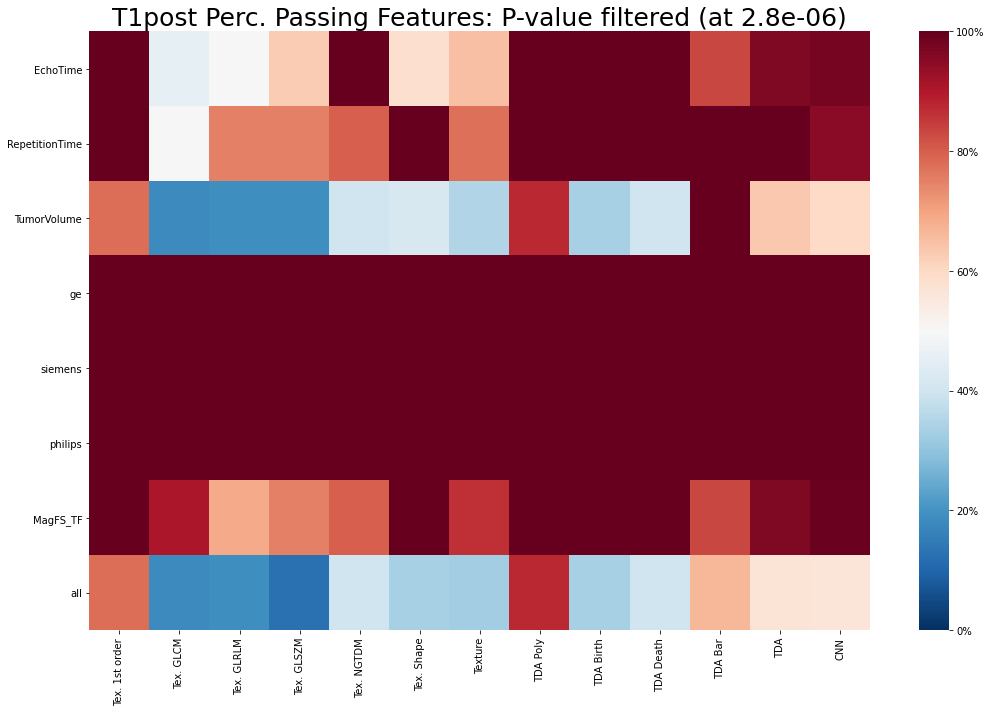

T1post                 Tex. 1st order  Tex. GLCM  Tex. GLRLM  Tex. GLSZM  Tex. NGTDM  \
EchoTime                    18         10           8          10           5   
RepetitionTime              18         11          12          12           4   
TumorVolume                 14          4           3           3           2   
ge                          18         22          16          16           5   
siemens                     18         22          16          16           5   
philips                     18         22          16          16           5   
MagFS_TF                    18         20          11          12           4   
all                         14          4           3           2           2   

                Tex. Shape  Texture  TDA Poly  TDA Birth  TDA Death  TDA Bar  \
EchoTime                 7       58         8          6         10        5   
RepetitionTime          12       69         8          6         10        6   
TumorVolume            

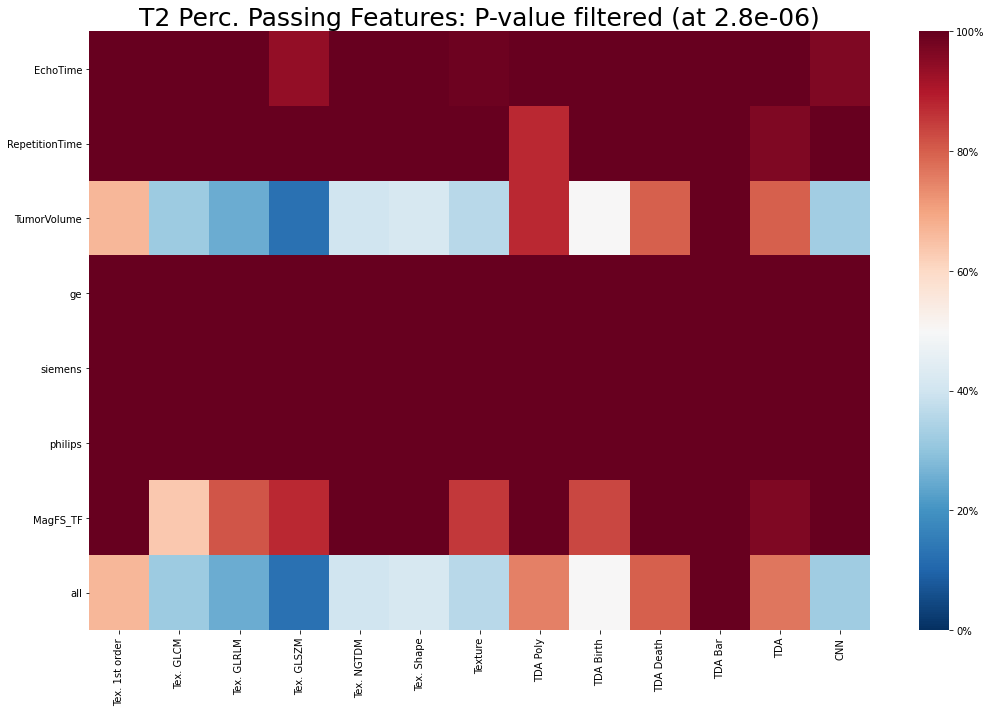

T2                 Tex. 1st order  Tex. GLCM  Tex. GLRLM  Tex. GLSZM  Tex. NGTDM  \
EchoTime                    18         22          16          15           5   
RepetitionTime              18         22          16          16           5   
TumorVolume                 12          7           4           2           2   
ge                          18         22          16          16           5   
siemens                     18         22          16          16           5   
philips                     18         22          16          16           5   
MagFS_TF                    18         14          13          14           5   
all                         12          7           4           2           2   

                Tex. Shape  Texture  TDA Poly  TDA Birth  TDA Death  TDA Bar  \
EchoTime                12       88         8          6         10        6   
RepetitionTime          12       89         7          6         10        6   
TumorVolume              5 

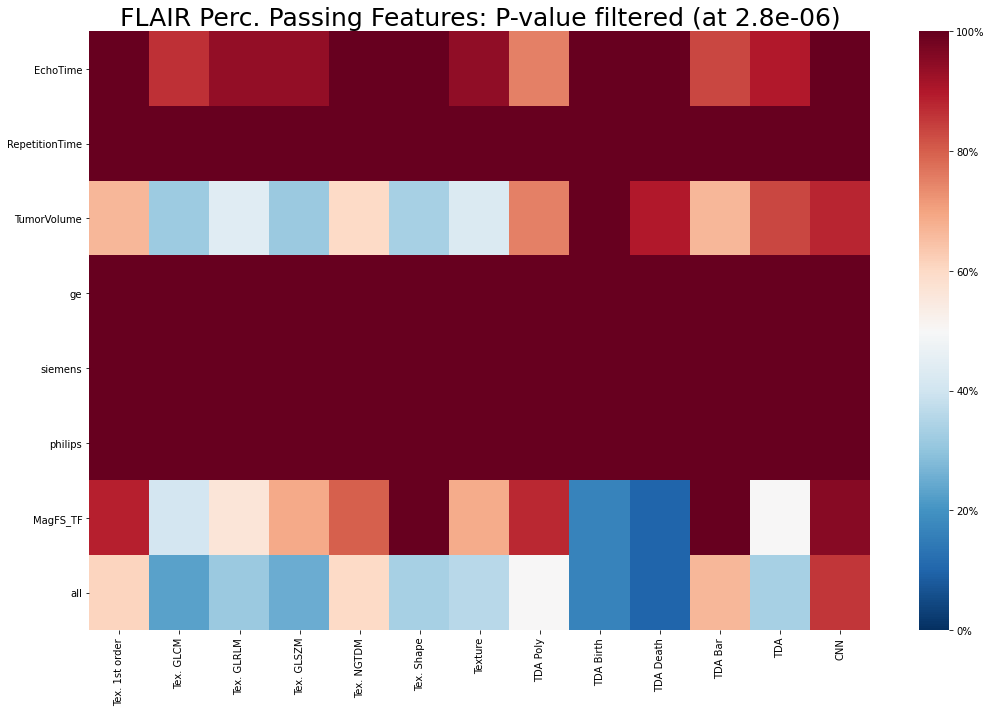

FLAIR                 Tex. 1st order  Tex. GLCM  Tex. GLRLM  Tex. GLSZM  Tex. NGTDM  \
EchoTime                    18         19          15          15           5   
RepetitionTime              18         22          16          16           5   
TumorVolume                 12          7           7           5           3   
ge                          18         22          16          16           5   
siemens                     18         22          16          16           5   
philips                     18         22          16          16           5   
MagFS_TF                    16          9           9          11           4   
all                         11          5           5           4           3   

                Tex. Shape  Texture  TDA Poly  TDA Birth  TDA Death  TDA Bar  \
EchoTime                12       84         6          6         10        5   
RepetitionTime          12       89         8          6         10        6   
TumorVolume             

In [3]:
modal_list = ['T1','T1post','T2','FLAIR']
manufacturer_list = ['ge','siemens','philips']
typeDict = {'Tex. 1st order':'firstorder_','Tex. GLCM':'glcm_','Tex. GLRLM':'glrlm_','Tex. GLSZM':'glszm_',
        'Tex. NGTDM':'ngtdm_','Tex. Shape': 'shape_',
        'Texture': '(firstorder_|glcm_|glrlm_|glszm_|ngtdm_|shape_)',
        'TDA Poly': 'polynomial_','TDA Birth': 'birth','TDA Death': 'death','TDA Bar':'bar length',
        'TDA':'(polynomial_|birth|death|bar length)',
        'CNN':'CNN'}

features_df = pd.DataFrame(data=all_samples, columns=all_feat_names, index=all_1p19q)
drop_features = ['shape_Flatness_', 'shape_LeastAxis_', 'shape_LeastAxisLength_']
drop_features = [elemt + modal for modal in modal_list for elemt in drop_features]

features_df = features_df.drop(drop_features, axis=1, errors = 'ignore')
feature_names = features_df.columns


# print(features_df)


outDict = {}
outStDict = {}
ctDict = {}
mDict = {}

for cModal in modal_list:
#     print(cModal)
    match = [bool(re.search('%s$' % cModal, fn)) for fn in feature_names]
    
    dcm_info = pd.read_csv(os.path.join(basedir,'data','%s_dcminfo.csv' %(cModal.lower())))
    dcm_info = dcm_info.set_index('TCGA_ID')
#     print(dcm_info['TCGA_ID'])
    # print(features_df)
    # dcm_info = dcm_info.set_index('TCGA_ID')
    # print(dcm_info)
    
    f_features_df = features_df.filter(feature_names[match])
    
    f_features_df['TCGA_ID'] = all_idstr.flatten()
    f_features_df = f_features_df.set_index('TCGA_ID')
    cmb_df = f_features_df.join(dcm_info,on='TCGA_ID')
#     dcm_info = pd.read_csv(os.path.join(basedir,'data','%s_dcminfo.csv' %(cModal.lower())))
    cmb_df.to_csv(os.path.join(splitdir,'dcm_feats_%s.csv' % (cModal)))
    
    for cMan in manufacturer_list:
        cmb_df['%s' % cMan] = cmb_df['Manufacturer'].str.contains(cMan, regex=False,case=False)*1
    cmb_df['MagFS_TF'] = (cmb_df['MagneticFieldStrength'] > 2.25) * 1
    feats_to_test = feature_names[match]
#     dcm_num_feats = ['EchoTime','RepetitionTime','MagneticFieldStrength', 'TumorVolume']
    dcm_num_feats = ['EchoTime','RepetitionTime', 'TumorVolume']
    dcm_feats_to_predict = dcm_num_feats + manufacturer_list + ['MagFS_TF']
    
    # build up list of 
    dcm_df = cmb_df.filter(dcm_feats_to_predict)
    feat_df = cmb_df.filter(feats_to_test)
    # print(feat_df)
    mask = np.logical_not(np.any(pd.isna(dcm_df.values),axis=1))
    dcm_df = dcm_df.loc[mask]
    feat_df = feat_df.loc[mask]
    scaler = preprocessing.MinMaxScaler().fit(dcm_df.filter(dcm_num_feats))
    norm_dcm_df = dcm_df
    norm_dcm_df[dcm_num_feats] = scaler.transform(dcm_df.filter(dcm_num_feats))
    
#     outArr = np.empty((len(feats_to_test),len(dcm_feats_to_test)))
#     outStArr = np.empty((len(feats_to_test),len(dcm_feats_to_test)))
#     for cfI in range(len(feats_to_test)):
#         cFeat = feats_to_test[cfI]
#         for dfI in range(len(dcm_feats_to_test)):
#             cDcmFt = dcm_feats_to_test[dfI]
#             cVec = cmb_df[cFeat]
#             dVec = cmb_df[cDcmFt]
#             mask = np.logical_not(np.logical_and(np.isnan(dVec),np.isnan(cVec)))
#             cMVec = cVec[mask] 
#             dMVec = dVec[mask]
#             print(cfI,dfI)
#             (st,pv) = pearsonr(cMVec,dMVec)
#             outArr[cfI,dfI] = pv
#             outStArr[cfI,dfI] = st
#         print(outArr,outStArr)
#         outDict[cModal] = outArr
#         outStDict[cModal] = outStArr
    outLRPVDF =  pd.DataFrame(index=norm_dcm_df.columns, columns=feats_to_test)
#     outLRAPVDF =  pd.DataFrame(index=norm_dcm_df.columns, columns=feats_to_test)
    outLRCEDF =  pd.DataFrame(index=norm_dcm_df.columns, columns=feats_to_test)
    for cFt in feats_to_test:
        fVec = cmb_df[cFt]
        fVec = fVec.loc[mask]
        # reg = linear_model.LinearRegression()
        # reg = reg.fit(norm_dcm_df, fVec)
        X2 = sm.add_constant(norm_dcm_df)
        est = sm.OLS(fVec, X2.astype(float))
        est2 = est.fit()
#         print(cFt,est2.summary())
        outLRPVDF[cFt] = est2.pvalues
#         outLRAPVDF[cFt] = est2.pvalues
        outLRCEDF[cFt] = est2.params
    
    outDict[cModal] = outLRPVDF
    outStDict[cModal] = outLRCEDF
    outLRPVDF.to_csv(os.path.join(splitdir,'dcm_PV_%s.csv' % (cModal)))
    outLRCEDF.to_csv(os.path.join(splitdir,'dcm_CE_%s.csv' % (cModal)))
    

#     print(typeDict)


    bonfThresh = .05 / (len(feats_to_test) * len(modal_list) * len(dcm_feats_to_predict))

    dcm_out_names = dcm_feats_to_predict + ["all"]
    mPV = pd.DataFrame(np.ones((len(dcm_out_names),len(typeDict))),columns=typeDict.keys(),index = dcm_out_names)
    ctPV = pd.DataFrame(np.ones((len(dcm_out_names),len(typeDict))),columns=typeDict.keys(),index = dcm_out_names)

    # print(mPV)
    # print(mPV['First order'])
    for fKey in typeDict.keys():
        fRe  = typeDict[fKey]
#         print(fRe)
        r = re.compile(fRe)
        ftList = list(filter(r.search, feats_to_test))
        cPV = outLRPVDF.filter(ftList)
        cPPV = (cPV > bonfThresh)*1
    #     print(cPPV)
    #     print(cPPV.mean(axis = 1))
        outArr = cPPV.mean(axis = 1)
        outArr['all'] = (cPPV.all(axis=0)*1).mean()
        mPV[fKey] = outArr
        outArr = cPPV.sum(axis = 1)
        outArr['all'] = (cPPV.all(axis=0)*1).sum()
        ctPV[fKey] = outArr
#         if fKey == 'Shape':
#             print(cPV)
    
    mDict[cModal] = mPV
    ctDict[cModal] = ctPV
    f, ax = plt.subplots(figsize=(15, 10))
    # Draw the heatmap using seaborn
    sns.heatmap(mPV*100, cmap = 'RdBu_r',vmin=0,vmax=100,
                cbar_kws={'format':  '%.0f%%'},ax=ax)
    plt.title("%s Perc. Passing Features: P-value filtered (at %4.2g)" % (cModal,bonfThresh), fontsize = 25)
    plt.tight_layout()
    imName = os.path.join(basedir,'images','DICOM_filt','PVal_perc_%s.png' % cModal)
    plt.savefig(imName, bbox_inches = "tight")
    plt.show()
    print(cModal,ctPV)
#     print(cmb_df)

                Tex. 1st order  Tex. GLCM  Tex. GLRLM  Tex. GLSZM  Tex. NGTDM  \
EchoTime                    68         56          43          44          18   
RepetitionTime              72         68          55          56          19   
TumorVolume                 51         22          16          12           9   
ge                          72         88          64          64          20   
siemens                     72         88          64          64          20   
philips                     72         88          64          64          20   
MagFS_TF                    69         64          47          51          18   
all                         48         20          14          10           9   

                Tex. Shape  Texture  TDA Poly  TDA Birth  TDA Death  TDA Bar  \
EchoTime                43      272        29         24         40       20   
RepetitionTime          44      314        31         24         40       24   
TumorVolume             23    

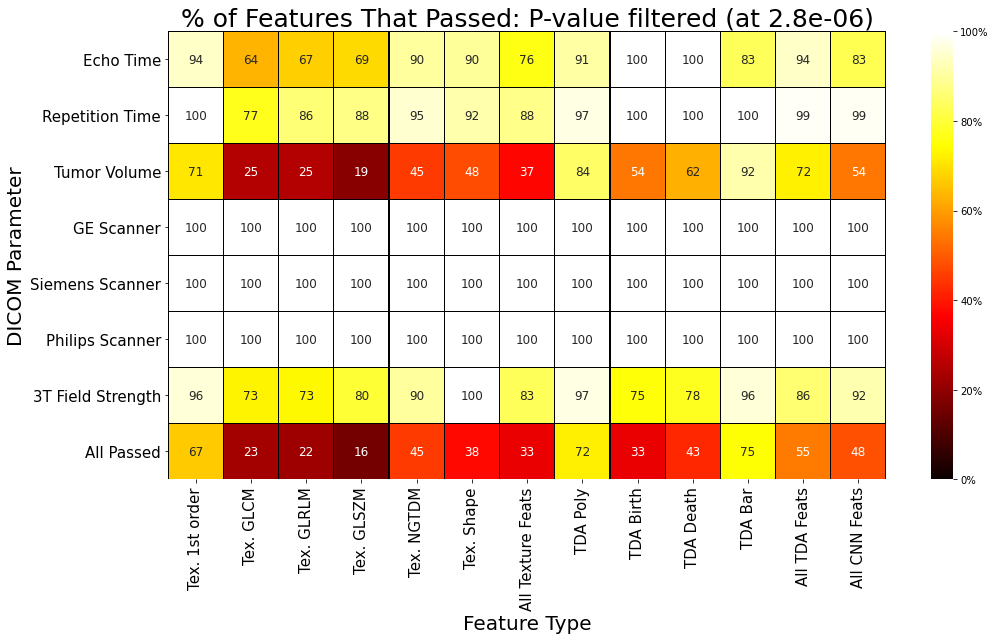

In [4]:
# print(mDict)
mMPV = mDict[modal_list[0]]
for cMi in range(1,len(modal_list)):
    cModal = modal_list[cMi]
    mMPV = mMPV + mDict[cModal]
mMPV = mMPV / len(modal_list)

aCtPV = ctDict[modal_list[0]]
for cMi in range(1,len(modal_list)):
    cModal = modal_list[cMi]
    aCtPV = aCtPV + ctDict[cModal]
print(aCtPV)
rowMap = {'EchoTime':'Echo Time', 'RepetitionTime':'Repetition Time', 'TumorVolume': 'Tumor Volume',
         'ge': 'GE Scanner','siemens': 'Siemens Scanner','philips': 'Philips Scanner', 
          'MagFS_TF':'3T Field Strength','all': 'All Passed'}
colMap = {'Texture': 'All Texture Feats','TDA':'All TDA Feats', 'CNN': 'All CNN Feats'}
mMPV = mMPV.rename(index=rowMap,columns = colMap)
# print(type(mMPV))
print(mMPV)
# ctDict[cModal] = ctPV
f, ax = plt.subplots(figsize=(15, 9))
ax.tick_params(axis='both', labelsize=15)
# Draw the heatmap using seaborn
sns.heatmap(mMPV*100, cmap = 'hot',vmin=0,vmax=100,linewidths=.2,linecolor='k',
            annot=True,fmt='.0f',
            annot_kws = {'fontsize': 12},
            cbar_kws={'format':  '%.0f%%'},ax = ax)

plt.xlabel('Feature Type',fontsize = 20)
plt.ylabel('DICOM Parameter',fontsize = 20)
plt.title("%% of Features That Passed: P-value filtered (at %4.2g)" % (bonfThresh), fontsize = 25)
plt.tight_layout()
imName = os.path.join(basedir,'images','DICOM_filt','PVal_perc.png')
plt.savefig(imName, bbox_inches = "tight")
plt.show()

In [10]:
print(range(1,len(modal_list)))

range(1, 4)


In [4]:
r = re.compile('mean')
ftList = list(filter(r.match, feats_to_test))
print(ftList,len(feats_to_test))
temp = [bool(re.search('mean',ft)) for ft in feats_to_test]
print(feats_to_test[temp])

['mean(birth)_0_FLAIR', 'mean(death)_0_FLAIR', 'mean(death_max-death)_0_FLAIR', 'mean(bar length)_0_FLAIR', 'mean(birth)_1_FLAIR', 'mean(death)_1_FLAIR', 'mean(death_max-death)_1_FLAIR', 'mean(bar length)_1_FLAIR'] 631
Index(['mean(birth)_0_FLAIR', 'mean(death)_0_FLAIR',
       'mean(death_max-death)_0_FLAIR', 'mean(bar length)_0_FLAIR',
       'mean(birth)_1_FLAIR', 'mean(death)_1_FLAIR',
       'mean(death_max-death)_1_FLAIR', 'mean(bar length)_1_FLAIR'],
      dtype='object')


In [5]:
combPVDF = pd.concat([df for df in outDict.values()], axis=1, sort=False)
dfDim = combPVDF.shape
bonfThresh = .05 / (dfDim[0] * dfDim[1])
print(dfDim,bonfThresh)
print(combPVDF.min(axis=0)> bonfThresh)
# print(ftPass['shape_LeastAxisLength_T1'])
ftPass = combPVDF.min(axis=0) > bonfThresh
print(np.count_nonzero(ftPass.values))
ftPass.to_csv(os.path.join(splitdir,'dcm_feats_tf.csv'))

(7, 2524) 2.8299750962191536e-06
firstorder_10Percentile_T1                    True
firstorder_90Percentile_T1                   False
firstorder_Energy_T1                          True
firstorder_Entropy_T1                        False
firstorder_InterquartileRange_T1              True
firstorder_Kurtosis_T1                        True
firstorder_Maximum_T1                        False
firstorder_Mean_T1                            True
firstorder_MeanAbsoluteDeviation_T1           True
firstorder_Median_T1                          True
firstorder_Minimum_T1                        False
firstorder_Range_T1                          False
firstorder_RobustMeanAbsoluteDeviation_T1     True
firstorder_RootMeanSquared_T1                 True
firstorder_Skewness_T1                       False
firstorder_TotalEnergy_T1                     True
firstorder_Uniformity_T1                     False
firstorder_Variance_T1                        True
glcm_Autocorrelation_T1                      Fals

In [6]:
cModal = 'T1'
match = [bool(re.search(cModal, fn)) for fn in feature_names]
f_features_df = features_df.filter(feature_names[match])
dcm_info = pd.read_csv(os.path.join(basedir,'data','%s_dcminfo.csv' %(cModal.lower())))
dcm_info = dcm_info.set_index('TCGA_ID')
#     print(dcm_info['TCGA_ID'])
# print(features_df)
# dcm_info = dcm_info.set_index('TCGA_ID')
# print(dcm_info)
f_features_df = features_df.filter(feature_names[match])
f_features_df['TCGA_ID'] = all_idstr.flatten()
f_features_df = f_features_df.set_index('TCGA_ID')
cmb_df = f_features_df.join(dcm_info,on='TCGA_ID')

In [7]:
dVec = cmb_df['MagneticFieldStrength']
print(range(len(dcm_feats_to_test)))

NameError: name 'dcm_feats_to_test' is not defined

In [ ]:
nFeats = len(feats_to_test)
nDcmFts = len(dcm_feats_to_test)
nModals = len(modal_list)
bonfCutoff = .05 / (nFeats * nDcmFts * nModals)
print(nDcmFts,nFeats,nModals,bonfCutoff)

In [ ]:
# turn the manufacturers into a boolean
manufacturer_list = ['ge','siemens','philips']
for cMan in manufacturer_list:
    cmb_df['%s' % cMan] = cmb_df['Manufacturer'].str.contains(cMan, regex=False,case=False)*1

cmb_df['MagFS_TF'] = (cmb_df['MagneticFieldStrength'] > 2.25) * 1

# print(cmb_df['ge_tf'],cmb_df['Manufacturer'])


In [5]:
from sklearn import preprocessing
dcm_num_feats = ['EchoTime','RepetitionTime','MagneticFieldStrength', 'TumorVolume']    
match = [bool(re.search('%s$' % cModal, fn)) for fn in feature_names]

feats_to_test = feature_names[match]

dcm_feats_to_predict = dcm_num_feats + manufacturer_list
print(dcm_feats_to_predict)
dcm_df = cmb_df.filter(dcm_feats_to_predict)
feat_df = cmb_df.filter(feats_to_test)
# print(feat_df)
mask = np.logical_not(np.any(pd.isna(dcm_df.values),axis=1))
dcm_df = dcm_df.loc[mask]
feat_df = feat_df.loc[mask]
# norm_feat_df = 
scaler = preprocessing.StandardScaler().fit(dcm_df.filter(dcm_num_feats))
norm_dcm_df = dcm_df
norm_dcm_df[dcm_num_feats] = scaler.transform(dcm_df.filter(dcm_num_feats))  
print(norm_dcm_df)
# print(mask)
# print(feat_df.shape)
# print(dcm_df.shape)
for cFt in feats_to_test:
    fVec = feat_df[cFt]
    
    

['EchoTime', 'RepetitionTime', 'MagneticFieldStrength', 'TumorVolume', 'ge', 'siemens', 'philips']
              EchoTime  RepetitionTime  MagneticFieldStrength  TumorVolume ge  \
TCGA_ID                                                                         
TCGA-02-0006  1.766302        0.142984               -1.37257    -0.936335  1   
TCGA-02-0006  1.766302        0.142984               -1.37257    -0.936335  1   
TCGA-02-0009  1.766302        0.142984               -1.37257    -1.089469  1   
TCGA-02-0009  1.766302        0.142984               -1.37257    -1.089469  1   
TCGA-02-0011  1.766302        0.142984               -1.37257     0.051068  1   
...                ...             ...                    ...          ... ..   
TCGA-HT-7694 -0.250259       -1.040079               -1.37257     2.632396  1   
TCGA-HT-7694 -0.250259       -1.040079               -1.37257     2.632396  1   
TCGA-HT-7694 -0.250259       -1.040079               -1.37257     2.632396  1   
TCGA-HT-76

In [6]:

# fVec = feat_df['CNN_000_FLAIR']
fts_to_predict = ['TumorVolume','RepetitionTime','CNN_001_%s' % cModal,'firstorder_Mean_%s' % cModal,'polynomial_1_0_%s' % cModal]
outLRPVDF =  pd.DataFrame(index=norm_dcm_df.columns, columns=fts_to_predict)
outLRCEDF =  pd.DataFrame(index=norm_dcm_df.columns, columns=fts_to_predict)
for cFt in fts_to_predict:
    fVec = cmb_df[cFt]
    fVec = fVec.loc[mask]
    # reg = linear_model.LinearRegression()
    # reg = reg.fit(norm_dcm_df, fVec)
    X2 = sm.add_constant(norm_dcm_df)
    # print(fVec.shape,X2.shape)
    est = sm.OLS(fVec, X2.astype(float))
    est2 = est.fit()
    print(cFt,est2.summary())
    outLRPVDF[cFt] = est2.pvalues
    outLRCEDF[cFt] = est2.params
print(outLRPVDF)
print(outLRCEDF)
# print(reg.coef_)
# print(est2.pvalues)

TumorVolume                             OLS Regression Results                            
Dep. Variable:            TumorVolume   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.950e+31
Date:                Wed, 15 Apr 2020   Prob (F-statistic):               0.00
Time:                        15:21:13   Log-Likelihood:                 9997.3
No. Observations:                 474   AIC:                        -1.998e+04
Df Residuals:                     466   BIC:                        -1.995e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const             

In [ ]:
from matplotlib.pyplot import scatter
scatter(dcm_df['TumorVolume'], fVec)

In [ ]:
dVec = dcm_df['TumorVolume']
# dVec = dVec.loc[mask]
fVec = cmb_df['firstorder_Mean_T1']
fVec = fVec.loc[mask]
(st,pv) = pearsonr(fVec,dVec)
print(st,pv)
scatter(dVec, fVec)

In [ ]:
from sklearn import preprocessing
dcm_num_feats = ['EchoTime','RepetitionTime','MagneticFieldStrength', 'TumorVolume']    
match = [bool(re.search('%s$' % cModal, fn)) for fn in feature_names]

feats_to_test = feature_names[match]

dcm_feats_to_predict = dcm_num_feats + manufacturer_list
print(dcm_feats_to_predict)
dcm_df = cmb_df.filter(dcm_feats_to_predict)
feat_df = cmb_df.filter(feats_to_test)
# print(feat_df)
mask = np.logical_not(np.any(pd.isna(dcm_df.values),axis=1))
dcm_df = dcm_df.loc[mask]
feat_df = feat_df.loc[mask]
# norm_feat_df = 
scaler = preprocessing.MinMaxScaler().fit(dcm_df.filter(dcm_num_feats))
norm_dcm_df = dcm_df
norm_dcm_df[dcm_num_feats] = scaler.transform(dcm_df.filter(dcm_num_feats))  
# print(norm_dcm_df)
# print(mask)
# print(feat_df.shape)
# print(dcm_df.shape)
for cFt in feats_to_test:
    fVec = feat_df[cFt]
    
    
# fVec = feat_df['CNN_000_FLAIR']
fts_to_predict = ['TumorVolume','RepetitionTime','CNN_001_%s' % cModal,'firstorder_Mean_%s' % cModal,'polynomial_1_0_%s' % cModal]
outLRPVDF =  pd.DataFrame(index=norm_dcm_df.columns, columns=fts_to_predict)
outLRCEDF =  pd.DataFrame(index=norm_dcm_df.columns, columns=fts_to_predict)
for cFt in fts_to_predict:
    fVec = cmb_df[cFt]
    fVec = fVec.loc[mask]
    # reg = linear_model.LinearRegression()
    # reg = reg.fit(norm_dcm_df, fVec)
    X2 = sm.add_constant(norm_dcm_df)
    # print(fVec.shape,X2.shape)
    est = sm.OLS(fVec, X2.astype(float))
    est2 = est.fit()
    print(cFt,est2.summary())
    outLRPVDF[cFt] = est2.pvalues
    outLRCEDF[cFt] = est2.params
# print(outLRPVDF)
# print(outLRCEDF)
# print(reg.coef_)
# print(est2.pvalues)